In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td
import events_utils.time_difference_2d as td2d
import events_utils.mvsec as mvsec_dset
import events_utils.flow as flow_utils

from scipy.spatial.transform import Rotation as R

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [120]:
#define time range
t_start = 13.51514835357666
duration = 0.5
t_end = t_start + duration
shape = (260, 346)
dataset = "data/MVSEC/"

In [121]:
events_raw = mvsec_dset.load_events_time(path + dataset + "indoor_flying1_data.hdf5", t_start, t_start+duration)

val: 1504645190.9405527
val: 1504645191.4405527
3114255
3233651
119396 events


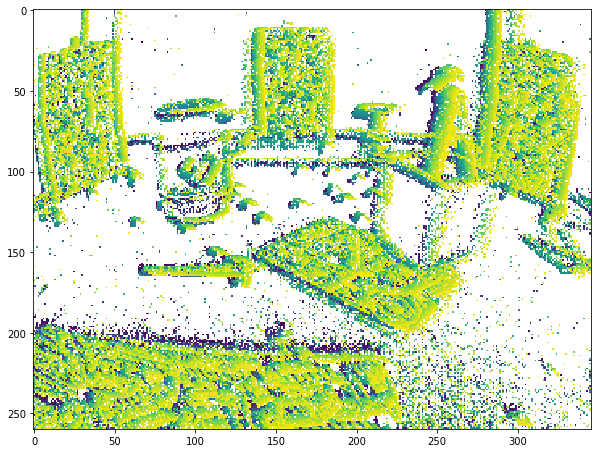

In [122]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events_raw, shape, filter_polarity=False, polarity=0)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")

In [123]:
## # patch_center = (100, 25)
# # patch_size = 20
# patch_center = (130, 173)
# patch_size = 240
# shape = (patch_size, patch_size)
# events_p = flt.filter_patch(events_raw, patch_center, patch_size)

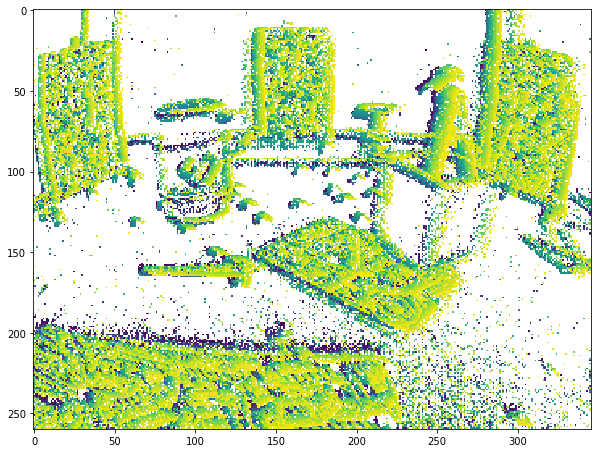

In [124]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events_raw, shape, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

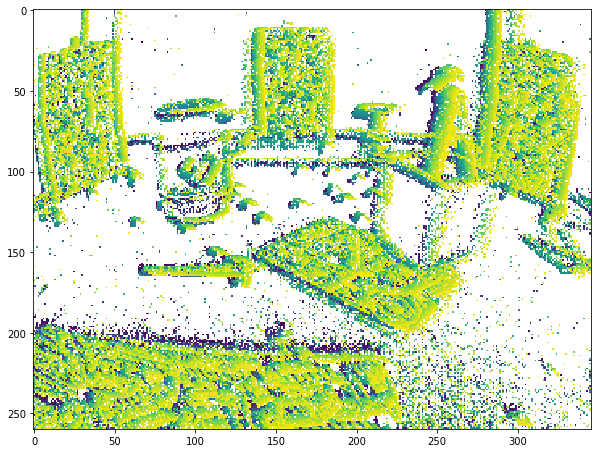

In [125]:
events, result_shape = flt.filter_conv(events_raw, shape, factor=1, thresh=1.0/2.0)
shape = result_shape
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events, result_shape, filter_polarity=False, polarity=0)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(ma

In [126]:
# patch_center = (100, 25)
# patch_size = 20
# # patch_center = (90, 90)
# # patch_size = 180
# shape = (patch_size, patch_size)
# events_p = flt.filter_patch(events, patch_center, patch_size)

In [127]:
# %matplotlib inline
# plt.figure(figsize=(10, 10))
# img = vis.events2time_surf(events_p, shape, filter_polarity=True, polarity=1)
# img_m = np.ma.masked_where(img == 0, img)
# m = plt.imshow(img_m, interpolation="none")
# #plt.colorbar(mappable=m)

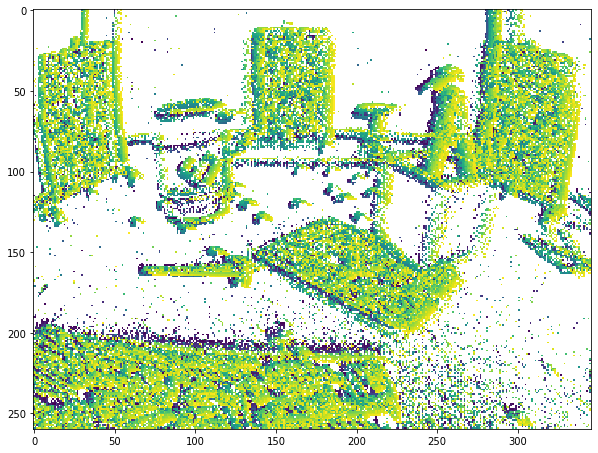

In [128]:
events_ref = flt.filter_refract(events, 0.2)
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events_ref, shape, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

In [129]:
events = events_ref

In [130]:
# shape = result_shape
# calib = np.loadtxt(path + dataset + "calib.txt")
focal_length = 226.38018519795807

In [131]:
poses = mvsec_dset.load_poses(path + dataset + "indoor_flying1_gt.hdf5")

C:\Users/schiavaz/lava-nc/depth\events_utils\mvsec.py:65: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  data_gt = h5py.File(f)


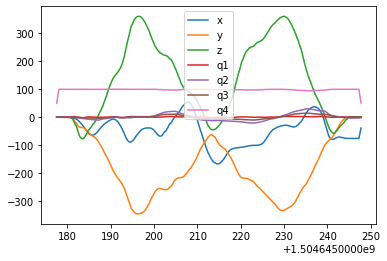

In [132]:
k = np.ones(100)
poses[:,1] = np.convolve(poses[:,1], k, mode="same")
poses[:,2] = np.convolve(poses[:,2], k, mode="same")
poses[:,3] = np.convolve(poses[:,3], k, mode="same")
poses[:,4] = np.convolve(poses[:,4], k, mode="same")
poses[:,5] = np.convolve(poses[:,5], k, mode="same")
poses[:,6] = np.convolve(poses[:,6], k, mode="same")
poses[:,7] = np.convolve(poses[:,7], k, mode="same")

plt.plot(poses[:,0], poses[:,1], label="x")
plt.plot(poses[:,0], poses[:,2], label="y")
plt.plot(poses[:,0], poses[:,3], label="z")
plt.plot(poses[:,0], poses[:,4], label="q1")
plt.plot(poses[:,0], poses[:,5], label="q2")
plt.plot(poses[:,0], poses[:,6], label="q3")
plt.plot(poses[:,0], poses[:,7], label="q4")
plt.legend()

In [133]:
def measure_td(events, shape, dist=1, start_delay=0.1):
    last_time = np.full(shape, -1.0)
    td_predictions = {}
    predictions = {}
    event_sign = np.full(shape, -1)

    U = np.zeros(shape)
    V = np.zeros(shape)

    start_time = events[0, 0]

    for e in tqdm(events):
        x = int(e[1])
        y = int(e[2])

        last_sign = event_sign[y, x]
        last_time[y, x] = e[0]
        event_sign[y, x] = e[3]

        if e[0] < start_time + start_delay:
            continue

        u_td = (e[0] - last_time[y - dist, x]
                if y - dist >= 0 and last_time[y - dist, x] != -1.0 and event_sign[y - dist, x] == e[3]
                else -1.0)
        d_td = (e[0] - last_time[y + dist, x]
                if y + dist < shape[0] and last_time[y + dist, x] != -1.0 and event_sign[y + dist, x] == e[3]
                else -1.0)
        r_td = (e[0] - last_time[y, x + dist]
                if x + dist < shape[1] and last_time[y, x + dist] != -1.0 and event_sign[y, x + dist] == e[3]
                else -1.0)
        l_td = (e[0] - last_time[y, x - dist]
                if x - dist >= 0 and last_time[y, x - dist] != -1.0 and event_sign[y, x - dist] == e[3]
                else -1.0)

        if u_td <= 0.0:
            if d_td <= 0.0:
                v_td = 0.0
                continue
            else:
                v_td = d_td
        else:
            if d_td > 0:
                #v_td = d_td if d_td >= u_td else -u_td
                v_td = 0.0
                continue
            else:
                v_td = -u_td

        if r_td <= 0.0:
            if l_td <= 0.0:
                h_td = 0.0
                continue
            else:
                h_td = l_td
        else:
            if l_td > 0:
                #h_td = l_td if l_td >= r_td else -r_td
                h_td = 0.0
                continue
            else:
                h_td = -r_td
                
        m = np.sqrt((h_td/ dist)**2 + (v_td/dist)**2)
        
        if m < 0.01:
            continue
                
        U[y, x] = h_td / dist #if h_td != 0.0 else 0.0
        V[y, x] = v_td / dist # if v_td != 0.0 else 0.0
        
    return U, V

In [137]:
# U, V = measure_td(events, shape, dist=2)
U, V, std_u, std_v = td2d.measure_td2(events, shape, dist=1, px_range_pred=7, std_thr=0.1, mean_thr=0.02, start_delay=0.02, final_delay=0.3)

100%|█████████████████████████████████████████████████████████████████████████| 93833/93833 [00:04<00:00, 19406.86it/s]


In [138]:
m = np.sqrt(U**2 + V**2)

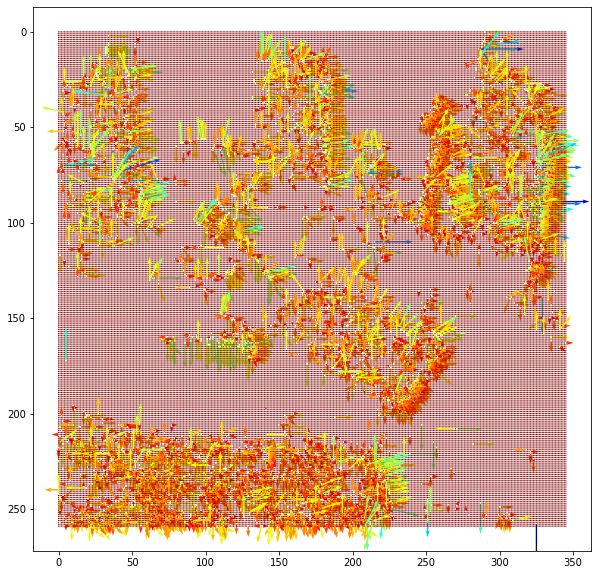

In [139]:
%matplotlib inline
plt.figure(figsize=(10, 10))
a = 1
plt.quiver(U[::a, ::a], V[::a, ::a], m[::a, ::a], cmap="jet_r")
plt.gca().invert_yaxis()

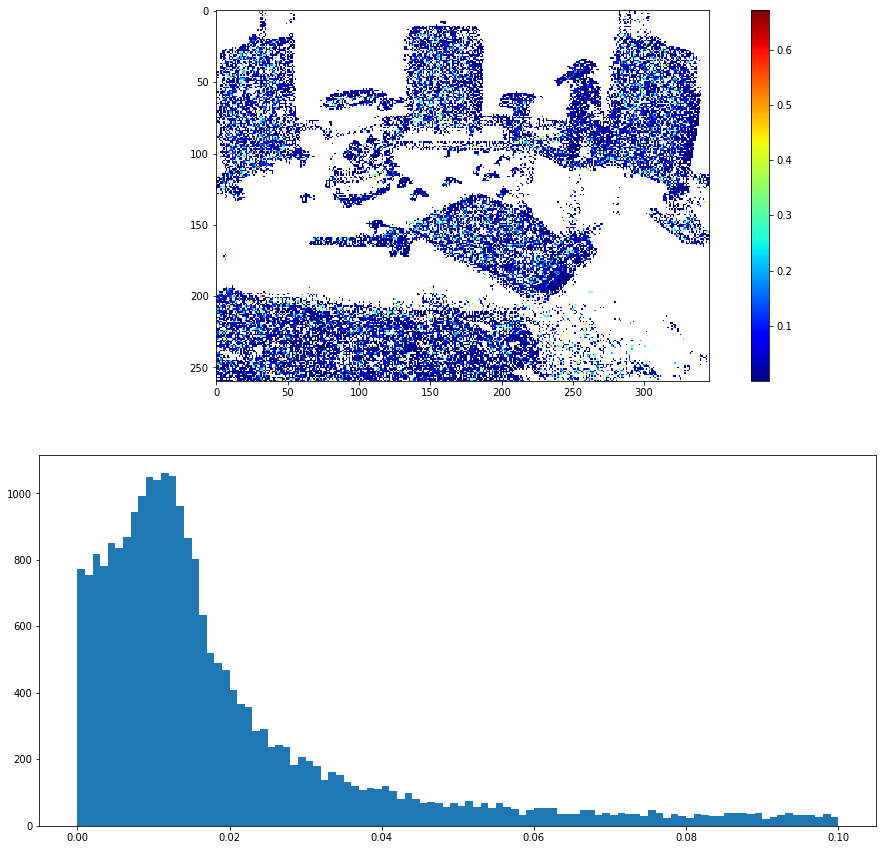

In [140]:
fig, axs = plt.subplots(2, figsize=(15, 15))
U_m = np.ma.masked_where(std_u==0.0, std_u)
m = axs[0].imshow(U_m, interpolation="none", cmap="jet")
fig.colorbar(m, ax=axs[0])
axs[1].hist(U_m.compressed(), 100, range=(0, .1));

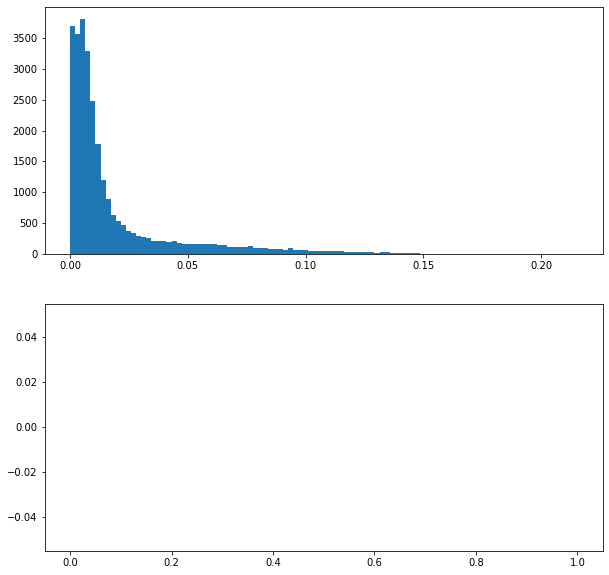

In [92]:
fig, axs = plt.subplots(2, figsize=(10, 10))
U_m = np.ma.masked_where(std_u == 0.0, std_u)
V_m = np.ma.masked_where(std_v == 0.0, std_v)
axs[0].hist(U_m.compressed(), 100);
axs[1].hist(V_m.compressed(), 100);

-0.014073689778645834
-0.00258783499399821
0.01476336295851549
---
0.011528153443514159
0.010624301317933715
0.008099284635737286


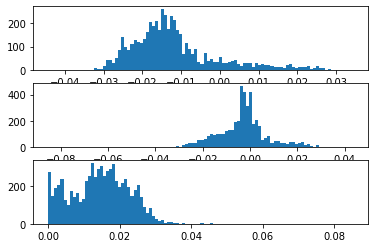

In [93]:
m = np.sqrt(U**2 + V**2)
u_m = np.ma.masked_where(np.isclose(U, 0.0), U)
v_m = np.ma.masked_where(np.isclose(V, 0.0), V)
m_m = np.ma.masked_where(np.isclose(m, 0.0), m)
fig, axs = plt.subplots(3)
axs[0].hist(u_m.compressed(), 100);
axs[1].hist(v_m.compressed(), 100);
axs[2].hist(m_m.compressed(), 100);
# plt.hist(u_m.compressed(), 100);
print(np.median(u_m.compressed()))
print(np.median(v_m.compressed()))
print(np.median(m_m.compressed()))
print("---")
print(np.std(u_m.compressed()))
print(np.std(v_m.compressed()))
print(np.std(m_m.compressed()))

In [94]:
odom = mvsec_dset.load_odom(path + dataset + "indoor_flying1_odom.npz")

In [95]:
C = np.array([173.6470807871759, 133.73271487507847]) 

C:\Users/schiavaz/lava-nc/depth\events_utils\mvsec.py:65: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  data_gt = h5py.File(f)


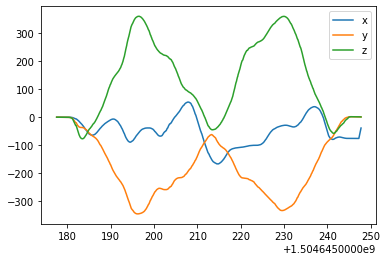

In [96]:
poses = mvsec_dset.load_poses(path + dataset + "indoor_flying1_gt.hdf5")
k = np.ones(100)
poses[:,1] = np.convolve(poses[:,1], k, mode="same")
poses[:,2] = np.convolve(poses[:,2], k, mode="same")
poses[:,3] = np.convolve(poses[:,3], k, mode="same")
poses[:,4] = np.convolve(poses[:,4], k, mode="same")
poses[:,5] = np.convolve(poses[:,5], k, mode="same")
poses[:,6] = np.convolve(poses[:,6], k, mode="same")
poses[:,7] = np.convolve(poses[:,7], k, mode="same")

# tmp = np.copy(poses[:,2])
# poses[:,2] = poses[:,3]
# poses[:,3] = tmp

plt.plot(poses[:,0], poses[:,1], label="x")
plt.plot(poses[:,0], poses[:,2], label="y")
plt.plot(poses[:,0], poses[:,3], label="z")
# plt.plot(poses[:,0], poses[:,4], label="q1")
# plt.plot(poses[:,0], poses[:,5], label="q2")
# plt.plot(poses[:,0], poses[:,6], label="q3")
# plt.plot(poses[:,0], poses[:,7], label="q4")
plt.legend()

In [97]:
# idx = np.searchsorted(poses[:, 0], t_start)
# pose1 = poses[idx]
# pose2 = poses[idx + 1]

# ang1 = R.from_quat(pose1[4:]).as_euler("xyz")
# ang2 = R.from_quat(pose2[4:]).as_euler("xyz")

# vel = (ang2 - ang1) / (pose2[0] - pose1[0])

# print(vel)

idx = np.searchsorted(odom[:,0], t_start + odom[0, 0])
ang_vel = odom[idx, 4:]
print(ang_vel)
print(idx)

[0.02756065 0.09526582 0.01196427]
970


In [98]:
# def get_angular_flow(w, f, shape):
#     U_flow = np.zeros(shape)
#     V_flow = np.zeros(shape)
#     for x in range(U_flow.shape[1]):
#         for y in range(U_flow.shape[0]):
#             xi = x - int(shape[1] / 2)
#             yi = y - int(shape[0] / 2)
#             # if np.mod(x, 10) != 0 or np.mod(y, 10) != 0:
#             #     continue
#             m = np.array([
#                 [(xi * yi) / f, -(f + xi ** 2 / f), yi],
#                 [f + yi ** 2 / f, -xi * yi / f, -xi]
#             ])
#             r = m @ w
#             U_flow[y, x] = r[0]
#             V_flow[y, x] = r[1]
            
#     return U_flow, V_flow

In [99]:
ang_U, ang_V = flow_utils.get_angular_flow(ang_vel, focal_length, C, shape)

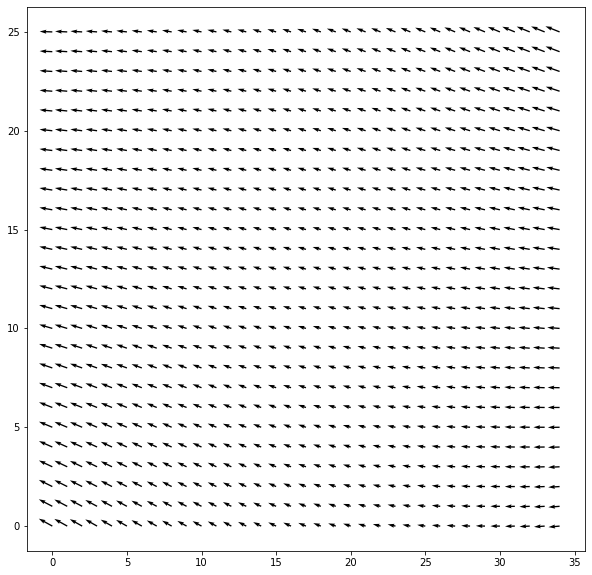

In [100]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(ang_U[::10, ::10], ang_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [101]:
# idx = np.searchsorted(poses[:, 0], t_start + 1.0)
# pose1 = poses[idx]
# pose2 = poses[idx + 10]

# t1 = pose1[1:4]
# t2 = pose2[1:4]

# print(t1)
# print(t2)

# t_vel = (t2 - t1) / (pose2[0] - pose1[0])

# print(t_vel)
# print(pose2[0] - pose1[0])
# # t_vel = np.array([0, 0, 0.1])

odom = mvsec_dset.load_odom(path + dataset + "indoor_flying1_odom.npz")
idx = np.searchsorted(odom[:, 0], t_start + odom[0, 0] )
t_vel = odom[idx, 1:4]
t_vel = t_vel * np.array([1, -1, 1])
print(idx)

970


In [102]:
# def get_translational_flow(t, f, shape):
#     U_flow = np.zeros(shape)
#     V_flow = np.zeros(shape)
#     for x in range(U_flow.shape[1]):
#         for y in range(U_flow.shape[0]):
#             xi = x - int(shape[1] / 2)
#             yi = y - int(shape[0] / 2)
#             # if np.mod(x, 10) != 0 or np.mod(y, 10) != 0:
#             #     continue
#             m = np.array([
#                 [-f, 0, xi],
#                 [0, -f, yi]
#             ])
#             r = m @ t
#             U_flow[y, x] = 1 / r[0]
#             V_flow[y, x] = 1 / r[1]
            
#     return U_flow, V_flow

In [103]:
t_U, t_V = flow_utils.get_translational_flow(t_vel, focal_length, C, shape)

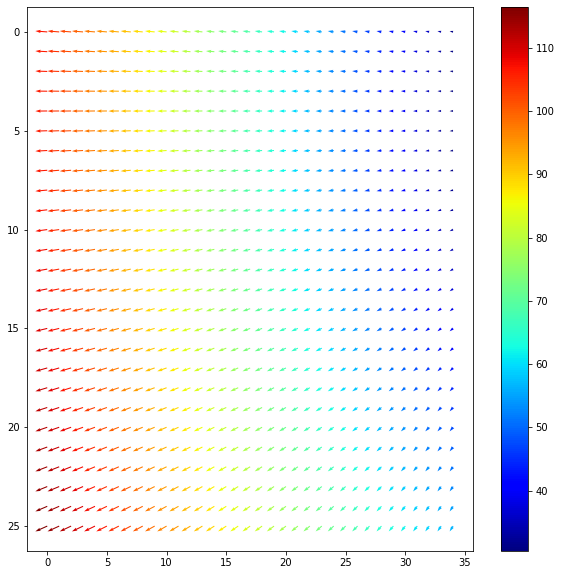

In [104]:
%matplotlib inline
plt.figure(figsize=(10, 10))
a = 10
m = np.sqrt(np.square(t_U) + np.square(t_V))
m = plt.quiver(t_U[::a, ::a], t_V[::a, ::a], m[::a, ::a], cmap="jet")
plt.colorbar(m)
plt.gca().invert_yaxis()

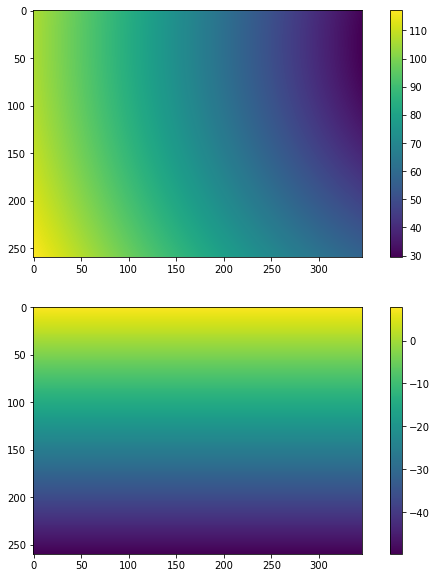

In [105]:
fig, axs = plt.subplots(2, figsize=(10, 10))
m = np.sqrt(np.square(t_U) + np.square(t_V))
m = axs[0].imshow(m)
fig.colorbar(m, ax=axs[0])

m = axs[1].imshow(t_V)
fig.colorbar(m, ax=axs[1])

In [106]:
flow_U = t_U + ang_U
flow_V = t_V + ang_V

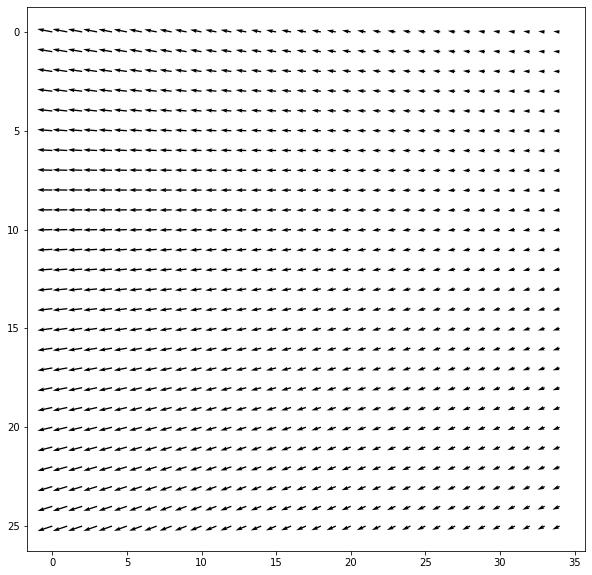

In [107]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(flow_U[::10, ::10], flow_V[::10, ::10], cmap="jet_r")
plt.gca().invert_yaxis()

In [108]:
# test_u = np.zeros(shape)
# test_v = np.zeros(shape)
# test = np.zeros(shape)
# for x in range(U.shape[1]):
#     for y in range(U.shape[0]):
        
#         m = np.sqrt(np.square(U[y, x]) + np.square(V[y, x])) ** 2
#         l = (ang_U[y, x]* U[y, x] + ang_V[y, x] * V[y, x]) / m

#         if m == 0.0:
#             continue
        
#         ang_p_u = U[y, x] * l
#         ang_p_v = V[y, x] * l
        
#         U_t = U[y, x]# - ang_p_u
#         V_t = V[y, x]# - ang_p_v
        
#         test_u[y, x] = U_t
#         test_v[y, x] = V_t
        
#         n = np.sqrt(t_U[y, x]**2 + t_V[y, x]**2) ** 2
#         p = (U_t*t_U[y, x] + V_t*t_V[y, x]) / n
        
#         u = 1 / (t_U[y, x] * p)
#         v = 1 / (t_V[y, x] * p)
        
#         test_u[y, x] = 1 / u
#         test_v[y, x] = 1 / v
        
#         tu = 1 / t_U[y, x] if t_U[y, x] != 0.0 else 0.0
#         tv = 1 / t_V[y, x] if t_V[y, x] != 0.0 else 0.0
        
#         a = tu / np.sqrt(tu**2 + tv**2)**2
#         b = tv / np.sqrt(tu**2 + tv**2)**2
        
#         z_inv = u * a + v * b
        
#         d = 1 / z_inv
        
#         if d<=0.0:
#             continue

#         test[y, x] = d

In [114]:
test, test_u, test_v =td2d.extract_depth3(shape, U, V, t_U, t_V)

0.6622280781719256


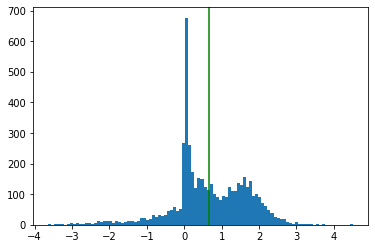

In [115]:
test_m = np.ma.masked_where(np.isclose(test, 0.0), test)
plt.hist(test_m.compressed(), 100);
# plt.axvline(x=0.581, c="red")
plt.axvline(x=np.ma.mean(test_m), c="green")
print(np.ma.mean(test_m))

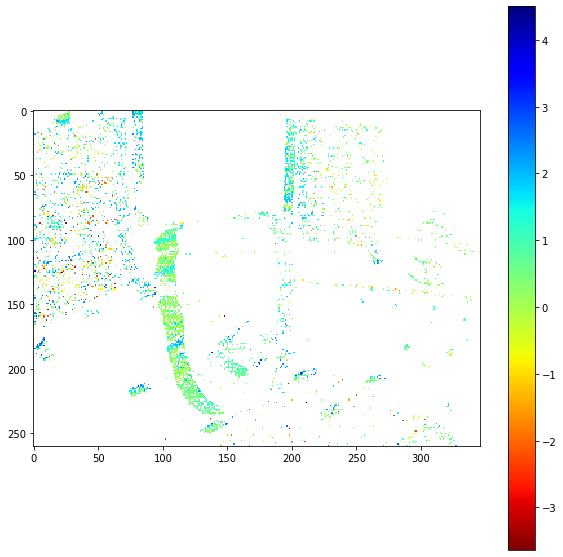

In [116]:
plt.figure(figsize=(10, 10))
# img_gray = plt.imread(path + dataset + "images/frame_00000057.png")
# plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(test_m, interpolation="none", cmap="jet_r")
plt.colorbar(m)

c:\users\schiavaz\lava-nc\venv\lib\site-packages\matplotlib\quiver.py:689: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
c:\users\schiavaz\lava-nc\venv\lib\site-packages\matplotlib\quiver.py:689: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


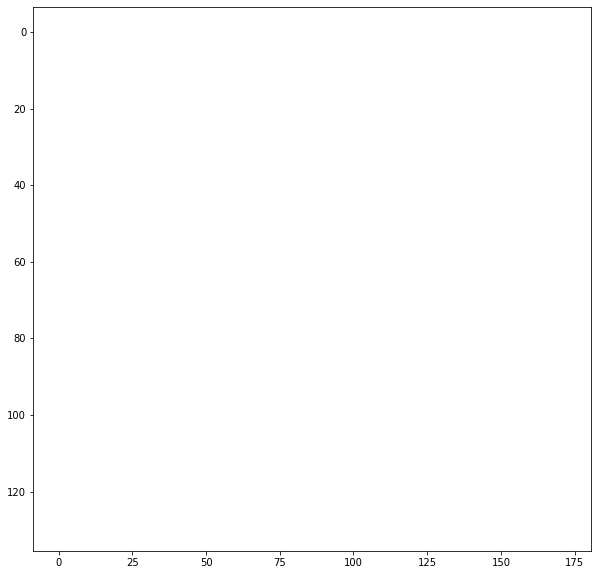

In [112]:
%matplotlib inline
plt.figure(figsize=(10, 10))
m = np.sqrt(np.square(test_v) + np.square(test_u))
a = 2
plt.quiver(test_u[::a, ::a], test_v[::a, ::a], m[::a, ::a], cmap="jet_r")
plt.gca().invert_yaxis()

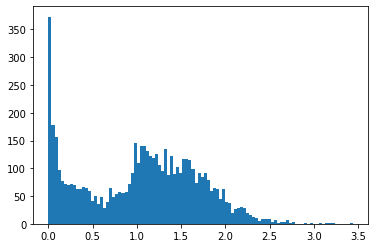

In [113]:
test_m = np.ma.masked_where(test == 0.0, test)
plt.hist(test_m.compressed(), 100);

In [70]:
depth_med = flt.median_filter(test_m, 9)
depth_med_m = np.ma.masked_where(depth_med == 0, depth_med)
# depth_r = flt.radius_filter(depth_med_m, 2, 4)

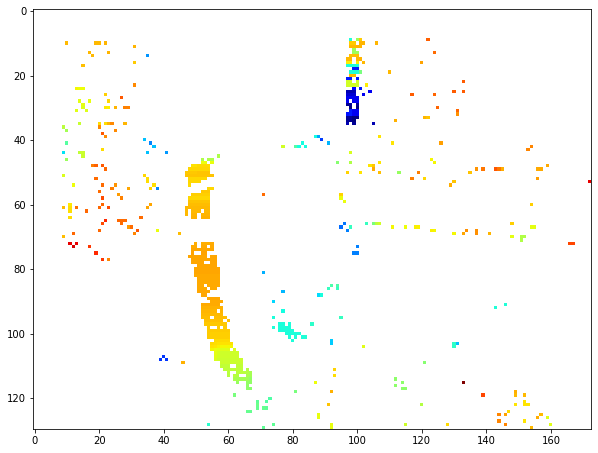

In [71]:
%matplotlib inline
plt.figure(figsize=(10, 10))
m = plt.imshow(depth_med_m, interpolation="none", cmap="jet_r")
# plt.colorbar(m)

In [49]:
# %matplotlib qt
# vis.visualize3d(depth_med_m, range=(0, 3))

In [50]:
d = test_m

In [51]:
gt_d = 0.584

In [52]:
mean_error = np.mean(np.abs(d.compressed() - gt_d))
print(mean_error)

1.1676471794135181


In [53]:
median_error = np.median(np.abs(d.compressed() - gt_d))
print(median_error)

1.1964165029093516


In [54]:
import hdf5plugin
import h5py

data = h5py.File(path + dataset + "indoor_flying1_data.hdf5")
imgs = np.array(data["davis"]["left"]["image_raw"])

C:\Users\schiavaz\AppData\Local\Temp/ipykernel_1040/985068459.py:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  data = h5py.File(path + dataset + "indoor_flying1_data.hdf5")


In [55]:
img_time = np.array(data["davis"]["left"]["image_raw_ts"])
idx = np.searchsorted(img_time, t_start + img_time[0] + 0.2)

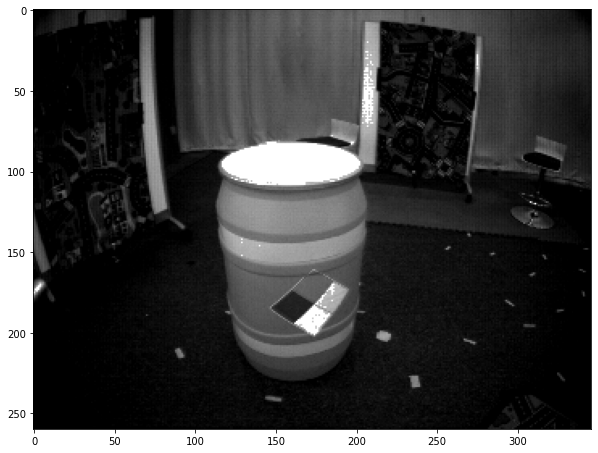

In [56]:
plt.figure(figsize=(10, 10))
plt.imshow(imgs[idx, :,:], cmap="gray")

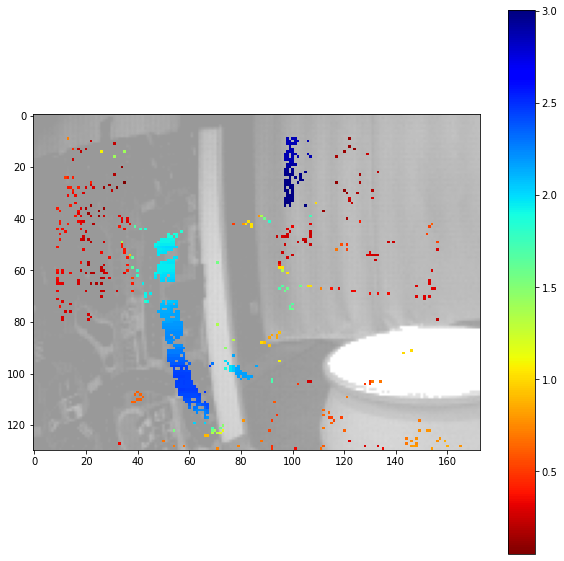

In [57]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = imgs[idx+1, ::, ::]
plt.imshow(img[::1, ::1], cmap="gray", alpha=0.4)
m = plt.imshow(depth_med_m, interpolation="none", cmap="jet_r")
plt.colorbar(m)

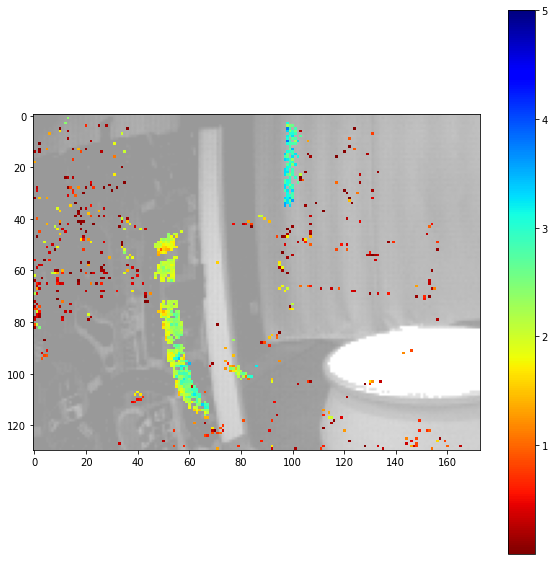

In [58]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(img[::1, ::1], cmap="gray", alpha=0.4)
m = plt.imshow(test_m, interpolation="none", cmap="jet_r", vmax=5)
plt.colorbar(m)

In [163]:
test1, test_u1, test_v1 =td2d.extract_depth2(shape, U, V, t_U, t_V)

In [164]:
test2, test_u2, test_v2 =td2d.extract_depth(shape, U, V, t_U, t_V)

In [165]:
test3, test_u3, test_v3 =td2d.extract_depth3(shape, U, V, t_U, t_V)

In [166]:
test4, test_u4, test_v4 =td2d.extract_depth4(shape, U, V, t_U, t_V)

In [167]:
diff = test4 - test3

In [168]:
np.max(diff)

167.82943507754158

In [169]:
np.min(diff)

-6.186815195448084